In [1]:
import os
import torch
import torch.nn as nn
import math

from functools import partial
from ray import tune, air
from ray.tune import CLIReporter, RunConfig
from ray.tune.tuner import Tuner

import datasets
import models
import train
import utils
import search_spaces

from adaptive_time_frequency import dastft_compute
from main import run_experiment
from produce_figures import produce_data_example_plot
from datasets import GaussPulseDatasetTimeFrequency

In [ ]:
num_samples = 1
max_epochs = 100
experiment_name = "time_frequency"
ray_root_dir = os.path.abspath("ray_results")
data_dir = os.path.abspath("data/time_frequency")

search_space = search_spaces.time_frequency(max_epochs)

reporter = CLIReporter(
    metric_columns=["loss", "valid_loss", "valid_acc", "best_valid_acc", "lambd_est", "training_iteration"],
    parameter_columns=["init_lambd", "trainable", "speaker_id", "model_name"],
    max_column_length=10
)


In [3]:
run_experiment_fn = partial(run_experiment, data_dir=data_dir)

trainable_with_resources = run_experiment_fn

tuner = Tuner(
    trainable_with_resources,
    param_space=search_space,
    run_config=RunConfig(
        name=experiment_name,
        storage_path=ray_root_dir,
        verbose=1,
        progress_reporter=reporter,
    ),
    tune_config=tune.TuneConfig(num_samples=num_samples),
)

results = tuner.fit()

2025-05-05 21:46:38,241	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-05 21:46:38,813	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2025-05-05 21:46:38,814	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-05-05 21:46:38,818	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-05-05 21:46:38,818	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2025-05-05 21:46:38 (running for 00:00:00.14)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-05-05_21-46-37_379167_675/artifacts/2025-05-05_21-46-38/time_frequency/driver_artifacts
Number of trials: 2/2 (2 PENDING)
+----------------------------+----------+-------+--------------+-------------+--------------+--------------+
| Trial name                 | status   | loc   | init_lambd   | trainable   | speaker_id   | model_name   |
|----------------------------+----------+-------+--------------+-------------+--------------+--------------|
| run_experiment_a9037_00000 | PENDING  |       | tenso_d8b0   | True        |              | linea_c770   |
| run_experiment_a9037_00001 | PENDING  |       | tenso_d950   | True        |              | linea_c770   |
+----------------------------+----------+-------+--------------+-------------+--------------+--------------+




(func pid=701) /Users/viktor/Documents/Spectral/projekt-fmsn35/differentiable-mel-spectrogram/utils.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(func pid=701)   init_lambd = torch.tensor(config['init_lambd']),


== Status ==
Current time: 2025-05-05 21:46:44 (running for 00:00:05.18)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-05-05_21-46-37_379167_675/artifacts/2025-05-05_21-46-38/time_frequency/driver_artifacts
Number of trials: 2/2 (2 RUNNING)
+----------------------------+----------+---------------+--------------+-------------+--------------+--------------+
| Trial name                 | status   | loc           | init_lambd   | trainable   | speaker_id   | model_name   |
|----------------------------+----------+---------------+--------------+-------------+--------------+--------------|
| run_experiment_a9037_00000 | RUNNING  | 127.0.0.1:701 | tenso_d8b0   | True        |              | linea_c770   |
| run_experiment_a9037_00001 | RUNNING  | 127.0.0.1:700 | tenso_d950   | True        |              | linea_c770   |
+----------------------------+----------+---------------+--------------+-------------+--------------+----

(func pid=701) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(func pid=701)   _log_deprecation_warning(


== Status ==
Current time: 2025-05-05 21:46:49 (running for 00:00:10.22)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-05-05_21-46-37_379167_675/artifacts/2025-05-05_21-46-38/time_frequency/driver_artifacts
Number of trials: 2/2 (2 RUNNING)
+----------------------------+----------+---------------+--------------+-------------+--------------+--------------+----------+--------------+-------------+--------------+-------------+--------------+
| Trial name                 | status   | loc           | init_lambd   | trainable   | speaker_id   | model_name   |     loss |   valid_loss |   valid_acc |   best_valid | lambd_est   |   training_i |
|                            |          |               |              |             |              |              |          |              |             |         _acc |             |     teration |
|----------------------------+----------+---------------+--------------+-------------+-

2025-05-05 21:49:24,516	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/viktor/Documents/Spectral/projekt-fmsn35/differentiable-mel-spectrogram/ray_results/time_frequency' in 0.0040s.
2025-05-05 21:49:24,519	INFO tune.py:1041 -- Total run time: 165.70 seconds (165.69 seconds for the tuning loop).


== Status ==
Current time: 2025-05-05 21:49:24 (running for 00:02:45.70)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-05-05_21-46-37_379167_675/artifacts/2025-05-05_21-46-38/time_frequency/driver_artifacts
Number of trials: 2/2 (2 TERMINATED)
+----------------------------+------------+---------------+--------------+-------------+--------------+--------------+----------+--------------+-------------+--------------+-------------+--------------+
| Trial name                 | status     | loc           | init_lambd   | trainable   | speaker_id   | model_name   |     loss |   valid_loss |   valid_acc |   best_valid | lambd_est   |   training_i |
|                            |            |               |              |             |              |              |          |              |             |         _acc |             |     teration |
|----------------------------+------------+---------------+--------------+----

In [6]:
best_result = results.get_best_result(metric="best_valid_acc", mode="max")

print(best_result.config)

print(best_result.metrics["best_valid_acc"])
print(best_result.metrics["lambd_est"])


{'model_name': 'linear_adaptive_net', 'hop_length': 1, 'optimized': False, 'normalize_window': False, 'optimizer_name': 'sgd', 'lr_model': 0.01, 'lr_tf': 1, 'batch_size': 16, 'trainable': True, 'max_epochs': 50, 'patience': 100, 'device': device(type='cpu'), 'n_points': 128, 'noise_std': 0.5, 'init_lambd': tensor([[8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]]), 'n_samples': 512, 'sigma_ref': 6.38, 'dataset_name': 'time_frequency', 'center_offset': False}
0.96875
[[8.087032318115234, 8.0819730758667, 8.041844367980957, 8.237177848815918, 8.77122688293457, 9.552020072937012, 10.38326358795166, 15.132803916931152, 10.844943046569824, 9.443102836608887, 8.815408706665039, 8.238767623901367, 8.08121109008789, 8.06892204284668, 8.021430015563965]]


NameError: name 'experiment_path' is not defined

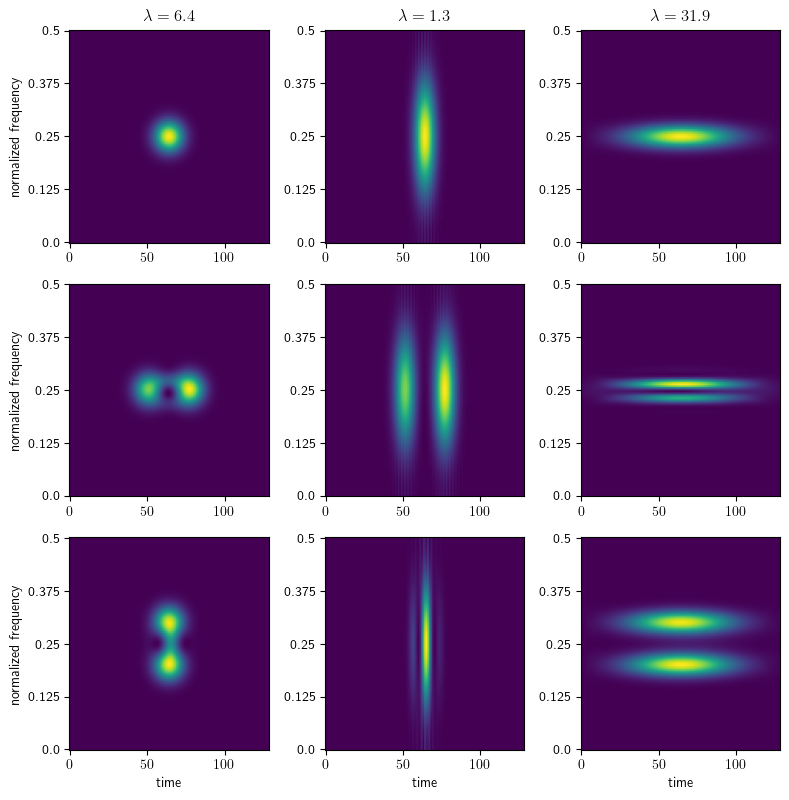

In [5]:
produce_data_example_plot()

Testing of adaptive STFT

In [ ]:
batch_size = 4
signal_length = 128
support = 32
stride = 4
F = int(1 + support / 2)
T = int(1 + (signal_length - (support - 1) - 1) // stride)

sigma_ref = torch.tensor(6.38)
dataset = datasets.GaussPulseDatasetTimeFrequency(
    sigma=sigma_ref,
    n_points=signal_length,
    noise_std=torch.tensor(0.05),
    n_samples=batch_size,
    demo=True
)

x = dataset.xs[:batch_size].float().to('cuda' if torch.cuda.is_available() else 'cpu')

stride_param = torch.tensor([stride], dtype=torch.float32, device=x.device) ## Fixed stride

## T adaptive
win_length_param = nn.Parameter(torch.full((1, T), support/2, device=x.device), requires_grad=True)
#win_length_param = nn.Parameter(
#    torch.linspace(support/8, support*0.95, T).view(1, T).to(x.device),
#    requires_grad=True
#)

## F adaptive
#win_length_param = nn.Parameter(
#    torch.linspace(support/4, support*0.8, F).view(F, 1),
#    requires_grad=True
#)

## TF adaptive
#win_length_param = nn.Parameter(torch.full((F, T), support/2, device=x.device), requires_grad=True)

spec, stft = dastft_compute(
    x=x,
    win_length_param=win_length_param,
    strides_param=stride_param,
    N=support,
    F=F,
    T=T,
    pow=1.0
)

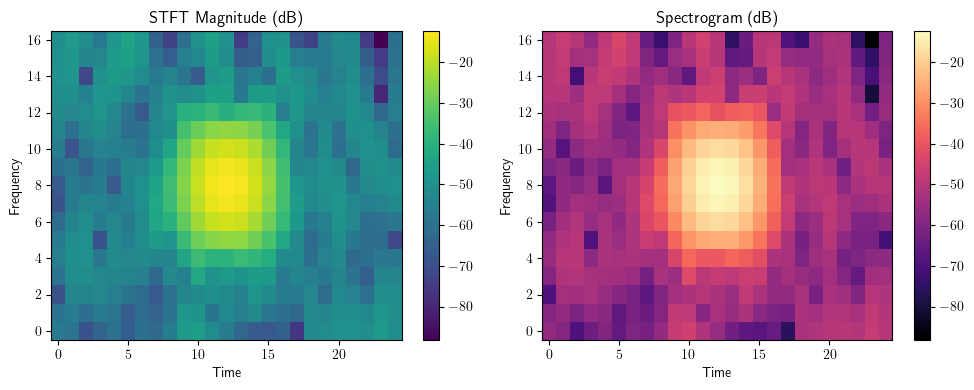

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

index = 0

stft_np = np.abs(stft[index].cpu().detach().numpy())
spec_np = spec[index].cpu().detach().numpy()

stft_db = 20 * np.log10(stft_np + 1e-10)
spec_db = 20 * np.log10(spec_np + 1e-10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

im1 = ax1.imshow(stft_db, aspect='auto', origin='lower', cmap='viridis')
ax1.set_title('STFT Magnitude (dB)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(spec_db, aspect='auto', origin='lower', cmap='magma')
ax2.set_title('Spectrogram (dB)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()